In [2]:
# We import libraries for linear algebra, graphs, and evaluation of results
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage import uniform_filter1d

# Keras is a high level neural networks library, based on either tensorflow or theano
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
    BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

In [3]:
# Load the data
# INPUT_LIB = '../input/'
raw_data = np.loadtxt( 'exoTrain.csv', skiprows=1, delimiter=',')
x_train = raw_data[:, 1:]
y_train = raw_data[:, 0, np.newaxis] - 1.
raw_data = np.loadtxt( 'exoTest.csv', skiprows=1, delimiter=',')
x_test = raw_data[:, 1:]
y_test = raw_data[:, 0, np.newaxis] - 1.
del raw_data

In [4]:
# Scale each observation to zero mean and unit variance.
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1, 1)) /
           np.std(x_train, axis=1).reshape(-1, 1))
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1, 1)) /
          np.std(x_test, axis=1).reshape(-1, 1))

In [5]:
# Add a feature corresponding to the running average over 200 time steps
x_train = np.stack([x_train, uniform_filter1d(x_train, axis=1, size=200)], axis=2)
x_test = np.stack([x_test, uniform_filter1d(x_test, axis=1, size=200)], axis=2)


In [6]:
# Define the model architecture
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=11, activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\hp\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Define a custom generator to handle class imbalance and for data augmentation
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')

    yes_idx = np.where(y_train[:, 0] == 1.)[0]
    non_idx = np.where(y_train[:, 0] == 0.)[0]

    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)

        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]

        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis=0)

        yield x_batch, y_batch

In [9]:
# --- CORRECTED TRAINING SECTION ---

# Compile and train the model in two phases

# Phase 1: Lower learning rate
print("Starting Phase 1 of training...")
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
# Use model.fit() instead of model.fit_generator()
hist = model.fit(batch_generator(x_train, y_train, 32),
                 validation_data=(x_test, y_test),
                 verbose=2,  # Changed to 2 for better progress visibility
                 epochs=5,
                 steps_per_epoch=x_train.shape[0] // 32) # Corrected steps_per_epoch

print("\nStarting Phase 2 of training...")
# Phase 2: Higher learning rate
model.compile(optimizer=Adam(4e-5), loss='binary_crossentropy', metrics=['accuracy'])
# Use model.fit() again for the second phase
hist_2 = model.fit(batch_generator(x_train, y_train, 32),
                   validation_data=(x_test, y_test),
                   verbose=2,
                   epochs=40,
                   steps_per_epoch=x_train.shape[0] // 32) # Corrected steps_per_epoch

# It's good practice to combine the history of both training phases for plotting
for key in hist.history.keys():
    hist.history[key].extend(hist_2.history[key])

Starting Phase 1 of training...
Epoch 1/5
158/158 - 5s - 30ms/step - accuracy: 0.4901 - loss: 0.7974 - val_accuracy: 0.8123 - val_loss: 0.6199
Epoch 2/5
158/158 - 2s - 11ms/step - accuracy: 0.5065 - loss: 0.7600 - val_accuracy: 0.7211 - val_loss: 0.6183
Epoch 3/5
158/158 - 2s - 11ms/step - accuracy: 0.5113 - loss: 0.7535 - val_accuracy: 0.6947 - val_loss: 0.6199
Epoch 4/5
158/158 - 2s - 11ms/step - accuracy: 0.5129 - loss: 0.7424 - val_accuracy: 0.6860 - val_loss: 0.6184
Epoch 5/5
158/158 - 2s - 10ms/step - accuracy: 0.5263 - loss: 0.7287 - val_accuracy: 0.6912 - val_loss: 0.6149

Starting Phase 2 of training...
Epoch 1/40
158/158 - 4s - 26ms/step - accuracy: 0.5439 - loss: 0.7096 - val_accuracy: 0.7053 - val_loss: 0.6177
Epoch 2/40
158/158 - 2s - 11ms/step - accuracy: 0.5823 - loss: 0.6918 - val_accuracy: 0.7351 - val_loss: 0.6045
Epoch 3/40
158/158 - 2s - 11ms/step - accuracy: 0.6161 - loss: 0.6599 - val_accuracy: 0.7561 - val_loss: 0.6005
Epoch 4/40
158/158 - 2s - 11ms/step - accura

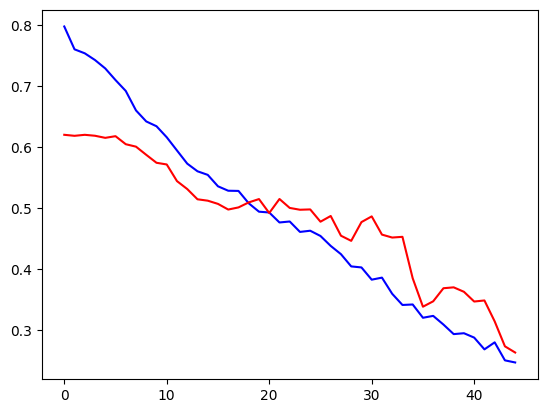

KeyError: 'acc'

In [10]:
# Plot training history
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

# Make predictions on the test set
non_idx = np.where(y_test[:, 0] == 0.)[0]
yes_idx = np.where(y_test[:, 0] == 1.)[0]
y_hat = model.predict(x_test)[:, 0]

# Plot the predicted scores for positive and negative classes
plt.plot([y_hat[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([y_hat[i] for i in non_idx], 'ro')
plt.show()

# Evaluate with ROC curve
y_true = (y_test[:, 0] + 0.5).astype("int")
fpr, tpr, thresholds = roc_curve(y_true, y_hat)
plt.plot(thresholds, 1. - fpr)
plt.plot(thresholds, tpr)
plt.show()
crossover_index = np.min(np.where(1. - fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]
crossover_specificity = 1. - fpr[crossover_index]
print("Crossover at {0:.2f} with specificity {1:.2f}".format(crossover_cutoff, crossover_specificity))
plt.plot(fpr, tpr)
plt.show()
print("ROC area under curve is {0:.2f}".format(roc_auc_score(y_true, y_hat)))

# Identify and plot false positives
false_positives = np.where(y_hat * (1. - y_test) > 0.5)[0]
for i in non_idx:
    if y_hat[i] > crossover_cutoff:
        print(i)
        plt.plot(x_test[i])
        plt.show()

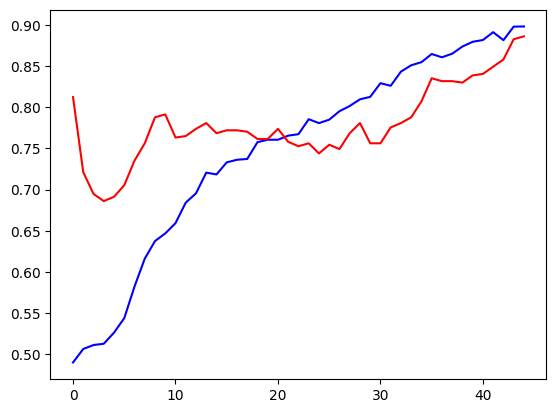

In [11]:
# This will work
plt.plot(hist.history['accuracy'], color='b')
plt.plot(hist.history['val_accuracy'], color='r')
plt.show()

Starting model evaluation...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
ROC Area Under Curve is 0.9961


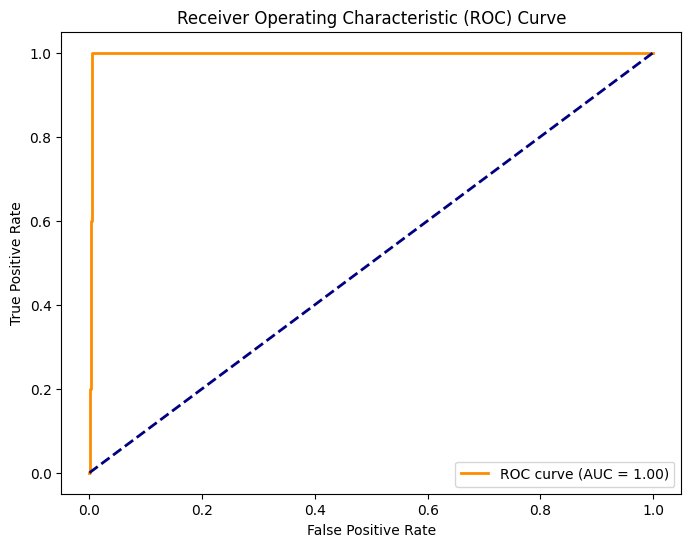

Optimal threshold (crossover point) is at 0.93

Generating Confusion Matrix...


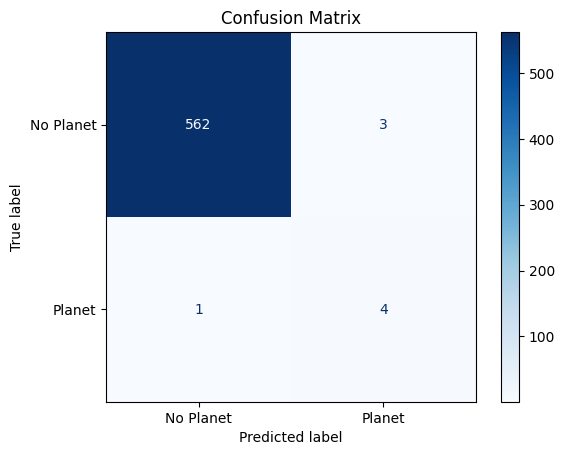


--- Confusion Matrix Breakdown ---
True Negatives (Correctly predicted 'No Planet'): 562
False Positives (Incorrectly predicted 'Planet'): 3
False Negatives (Incorrectly predicted 'No Planet'): 1
True Positives (Correctly predicted 'Planet'):  4
------------------------------------


In [15]:
# --- COMPLETE AND CORRECTED EVALUATION SECTION ---

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Starting model evaluation...")

# 1. MAKE PREDICTIONS (This creates the 'y_hat' variable)
# Get the model's probability predictions on the test set.
y_hat = model.predict(x_test)[:, 0]

# 2. PREPARE THE TRUE LABELS
# Convert the y_test labels into the correct integer format for scikit-learn.
y_true = (y_test[:, 0] + 0.5).astype("int")

# 3. CALCULATE ROC CURVE and AUC SCORE
# This is necessary to find the best threshold for our predictions.
fpr, tpr, thresholds = roc_curve(y_true, y_hat)
auc_score = roc_auc_score(y_true, y_hat)
print(f"ROC Area Under Curve is {auc_score:.4f}")

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


# 4. FIND THE BEST THRESHOLD
# We'll use the threshold where the true positive rate and (1 - false positive rate) cross.
crossover_index = np.min(np.where(tpr >= 1. - fpr))
crossover_cutoff = thresholds[crossover_index]
print(f"Optimal threshold (crossover point) is at {crossover_cutoff:.2f}")


# 5. GENERATE AND DISPLAY THE CONFUSION MATRIX
print("\nGenerating Confusion Matrix...")
# Convert probability scores into final 0 or 1 predictions using our optimal threshold.
y_pred = (y_hat > crossover_cutoff).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No Planet', 'Planet'])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# You can also print the raw numbers
print("\n--- Confusion Matrix Breakdown ---")
print(f"True Negatives (Correctly predicted 'No Planet'): {cm[0, 0]}")
print(f"False Positives (Incorrectly predicted 'Planet'): {cm[0, 1]}")
print(f"False Negatives (Incorrectly predicted 'No Planet'): {cm[1, 0]}")
print(f"True Positives (Correctly predicted 'Planet'):  {cm[1, 1]}")
print("------------------------------------")

In [14]:
# --- RECOMMENDED TRAINING CODE ---

# Phase 1: Lower learning rate
print("Starting Phase 1 of training...")
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(batch_generator(x_train, y_train, 32),
                 validation_data=(x_test, y_test),
                 verbose=2,
                 epochs=5,
                 steps_per_epoch=x_train.shape[0] // 32)

print("\nStarting Phase 2 of training...")
# Phase 2: Higher learning rate
model.compile(optimizer=Adam(4e-5), loss='binary_crossentropy', metrics=['accuracy'])
hist_2 = model.fit(batch_generator(x_train, y_train, 32),
                   validation_data=(x_test, y_test),
                   verbose=2,
                   epochs=40,
                   steps_per_epoch=x_train.shape[0] // 32)

# Combine the history for plotting
for key in hist.history.keys():
    hist.history[key].extend(hist_2.history[key])

Starting Phase 1 of training...
Epoch 1/5
158/158 - 4s - 27ms/step - accuracy: 0.9037 - loss: 0.2465 - val_accuracy: 0.8912 - val_loss: 0.2639
Epoch 2/5
158/158 - 2s - 11ms/step - accuracy: 0.8993 - loss: 0.2488 - val_accuracy: 0.8947 - val_loss: 0.2522
Epoch 3/5
158/158 - 2s - 11ms/step - accuracy: 0.8960 - loss: 0.2469 - val_accuracy: 0.8947 - val_loss: 0.2572
Epoch 4/5
158/158 - 2s - 11ms/step - accuracy: 0.9039 - loss: 0.2491 - val_accuracy: 0.8930 - val_loss: 0.2546
Epoch 5/5
158/158 - 2s - 11ms/step - accuracy: 0.9053 - loss: 0.2391 - val_accuracy: 0.8982 - val_loss: 0.2407

Starting Phase 2 of training...
Epoch 1/40
158/158 - 4s - 27ms/step - accuracy: 0.9106 - loss: 0.2275 - val_accuracy: 0.9228 - val_loss: 0.1959
Epoch 2/40
158/158 - 2s - 10ms/step - accuracy: 0.9005 - loss: 0.2455 - val_accuracy: 0.9070 - val_loss: 0.2320
Epoch 3/40
158/158 - 2s - 11ms/step - accuracy: 0.9110 - loss: 0.2228 - val_accuracy: 0.9035 - val_loss: 0.2291
Epoch 4/40
158/158 - 2s - 11ms/step - accura

C:\Users\hp\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting training with Learning Rate Scheduler...
Epoch 1/100
158/158 - 6s - 37ms/step - accuracy: 0.5953 - loss: 0.6925 - val_accuracy: 0.1263 - val_loss: 0.8393 - learning_rate: 1.0000e-04
Epoch 2/100
158/158 - 3s - 20ms/step - accuracy: 0.6624 - loss: 0.6166 - val_accuracy: 0.7509 - val_loss: 0.6205 - learning_rate: 1.0000e-04
Epoch 3/100
158/158 - 3s - 20ms/step - accuracy: 0.7300 - loss: 0.5448 - val_accuracy: 0.8105 - val_loss: 0.4817 - learning_rate: 1.0000e-04
Epoch 4/100
158/158 - 3s - 21ms/step - accuracy: 0.7581 - loss: 0.4981 - val_accuracy: 0.7491 - val_loss: 0.5247 - learning_rate: 1.0000e-04
Epoch 5/100
158/158 - 4s - 22ms/step - accuracy: 0.7919 - loss: 0.4470 - val_accuracy: 0.7596 - val_loss: 0.5056 - learning_rate: 1.0000e-04
Epoch 6/100
158/158 - 3s - 21ms/step - accuracy: 0.8281 - loss: 0.3872 - val_accuracy: 0.7965 - val_loss: 0.4344 - learning_rate: 1.0000e-04
Epoch 7/100
158/158 - 3s - 22ms/step - accuracy: 0.8801 - loss: 0.2976 - val_accuracy: 0.8947 - val_loss

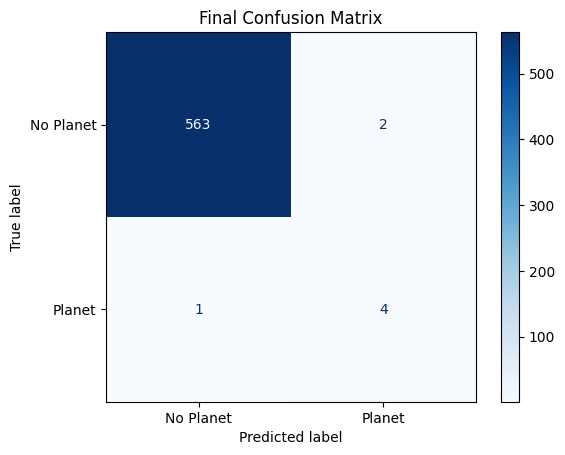


--- Final Confusion Matrix Breakdown ---
Accuracy: 99.4737%
True Negatives: 563
False Positives: 2
False Negatives: 1
True Positives:  4
------------------------------------


In [16]:
# --- ADVANCED TRAINING AND EVALUATION BLOCK ---

from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. DEFINE A SLIGHTLY DEEPER MODEL ARCHITECTURE
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=11, activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
# Adding one more convolutional block to make the network deeper
model.add(Conv1D(filters=128, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 2. COMPILE THE MODEL
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 3. SET UP A LEARNING RATE SCHEDULER
# This will automatically reduce the learning rate if the validation loss doesn't improve.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-6, verbose=1)

# 4. TRAIN THE MODEL USING THE GENERATOR AND THE SCHEDULER
# We train for more epochs, and the scheduler will handle the learning rate.
print("Starting training with Learning Rate Scheduler...")
hist = model.fit(batch_generator(x_train, y_train, 32),
                 validation_data=(x_test, y_test),
                 verbose=2,
                 epochs=100,  # Train for longer
                 steps_per_epoch=x_train.shape[0] // 32,
                 callbacks=[reduce_lr]) # Add the scheduler here

# 5. EVALUATE THE FINAL MODEL (same as before)
print("\nEvaluating the final model...")
y_hat = model.predict(x_test)[:, 0]
y_true = (y_test[:, 0] + 0.5).astype("int")

fpr, tpr, thresholds = roc_curve(y_true, y_hat)
crossover_index = np.min(np.where(tpr >= 1. - fpr))
crossover_cutoff = thresholds[crossover_index]
y_pred = (y_hat > crossover_cutoff).astype(int)

# Display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Planet', 'Planet'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Final Confusion Matrix")
plt.show()

print("\n--- Final Confusion Matrix Breakdown ---")
print(f"Accuracy: {((cm[0,0] + cm[1,1]) / cm.sum() * 100):.4f}%")
print(f"True Negatives: {cm[0, 0]}")
print(f"False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]}")
print(f"True Positives:  {cm[1, 1]}")
print("------------------------------------")